In [136]:
library(tidyr)
library(ggplot2)
library(ggpubr)
library(dplyr)

In [137]:
df<-read.csv("../Figure5/05_Correlation_Analysis/selected_pairs_set3.csv",check.names = FALSE)
names(df)[is.na(names(df)) | names(df) == ""] <- paste0("V", which(is.na(names(df)) | names(df) == ""))
df_filtered <- df %>% filter(rowSums(is.na(.)) == 0)

In [140]:
df_filtered<-df_filtered %>% filter (!(variable=="IgG2_to_Total_Ratio_D7_Phuket_2020-2021" &value>0.015))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


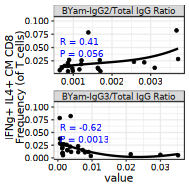

In [148]:


options(repr.plot.width = 40/25.4, repr.plot.height =  40/25.4)

p <- ggplot(df_filtered  , aes(y = `TCR-IFNg+ IL4+ CD27+ CM Memory CD8+`, 
                                                                                     x = value)) +
  geom_point(size = 0.6, stroke = 0.25) +
  geom_smooth(method = 'loess', color = "black", se = FALSE,span = 1.8, linewidth = 0.5) +
  stat_cor(
    method = "spearman",
    aes(label = paste0("R = ", ..r.., "\nP = ", ..p..)),
    label.x.npc = "left", 
    label.y.npc = "top",   output.type = "text",
color ="blue",
    size = 1.76
  ) +
  facet_wrap(~ variable, ncol = 1, scales = "free",labeller = labeller(variable = c(
      "IgG2_to_Total_Ratio_D7_Phuket_2020-2021"="BYam-IgG2/Total IgG Ratio",
      "IgG3_to_Total_Ratio_D7_Phuket_2020-2021"="BYam-IgG3/Total IgG Ratio"
  ))) +
  theme_bw(base_size = 6) + scale_y_continuous(expand = expansion(mult = c(0.05, 0.35))) + theme(
  axis.title   = element_text(color = "black"),
  axis.text    = element_text(color = "black"),
  strip.text.x      = element_text(margin = margin(t = 1, b = 1)))+
ylab("IFNg+ IL4+ CM CD8\nFrequency (of T cells)")

p
ggsave('FigureJ1.pdf',
       p,
       width = 45/25.4,
       height = 40/25.4)